# Approximating a double pendulum

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM, CuDNNLSTM, Bidirectional

import random
from random import seed, random
from sklearn.utils import shuffle

%matplotlib inline

/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [8]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

# Pendulum rod lengths (m), bob masses (kg).
L1, L2 = 0.02785, 0.0251
m1, m2 = 0.399, 0.276
# The gravitational acceleration (m.s-2).
g = 9.81

def deriv(y, t, L1, L2, m1, m2):
    """Return the first derivatives of y = theta1, z1, theta2, z2."""
    theta1, z1, theta2, z2 = y

    c, s = np.cos(theta1-theta2), np.sin(theta1-theta2)

    theta1dot = z1
    z1dot = (m2*g*np.sin(theta2) - m2*s*(L1*z1**2*c + L2*z2**2) -
             (m1+m2)*g*np.sin(theta1)) / L1 / (m1 + m2*s**2)
    theta2dot = z2
    z2dot = ((m1+m2)*(L1*z1**2*s - g*np.sin(theta2) + g*np.sin(theta1)*c) + 
             m2*L2*z2**2*s*c) / L2 / (m1 + m2*s**2)
    return theta1dot, z1dot, theta2dot, z2dot

# Maximum time, time point spacings and the time grid (all in s).
tmax, dt = 10, 0.01
t = np.arange(0, tmax+dt, dt)
# Initial conditions.
div1 = 2
div2 = 2
y0 = [np.pi/div1, 0, 0, 0]

# Do the numerical integration of the equations of motion
y = odeint(deriv, y0, t, args=(L1, L2, m1, m2))
# Unpack z and theta as a function of time
theta1, theta1dot, theta2, theta2dot  = y[:,0], y[:,1], y[:,2], y[:,3]

# Convert to Cartesian coordinates of the two bob positions.
x1 = L1 * np.sin(theta1)
y1 = -L1 * np.cos(theta1)
x2 = x1 + L2 * np.sin(theta2)
y2 = y1 - L2 * np.cos(theta2)

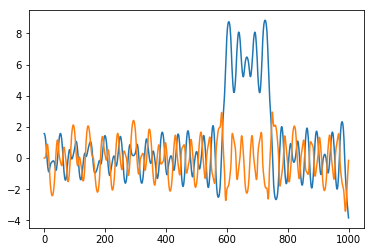

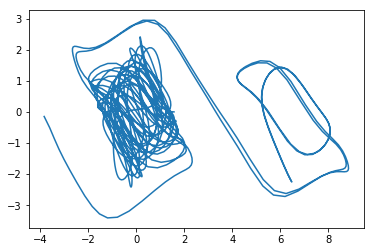

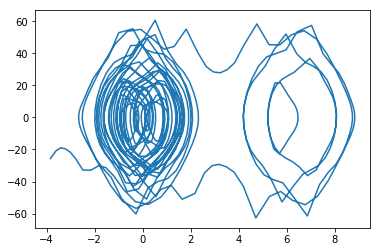

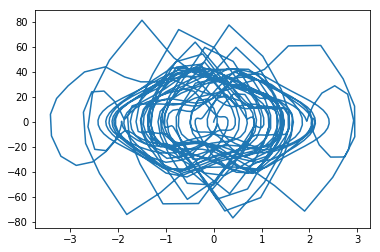

In [9]:
plt.plot(theta1)
plt.plot(theta2)
theta_pair = [[x[0], x[1]] for x in zip(theta1, theta2)]
data = theta_pair
plt.figure()
plt.plot(theta1, theta2)
plt.figure()
plt.plot(theta1, theta1dot)
plt.figure()
plt.plot(theta2, theta2dot)

In [10]:
# hyperparameters
DATA_DIM = 2
N_PREV = 100 # number of previous steps used to predict the next step

In [11]:
def _load_data(data, n_prev=N_PREV, is_shuffled=False):
    """
    data should be pd.DataFrame()
    """
    docX, docY = [], []
    for i in range(len(data)-n_prev):
        docX.append(data[i:i+n_prev])
        docY.append(data[i+n_prev])
    alsX = np.array(docX)
    alsY = np.array(docY)
    if is_shuffled: 
        alsX, alsY = shuffle(alsX, alsY)

    return alsX, alsY

def train_test_split(df, test_size=0.2):  
    """
    This just splits data to training and testing parts
    """
    ntrn = int(round(len(df) * (1 - test_size)))

    X_train, y_train = _load_data(df[0:ntrn], is_shuffled=True)
    X_test, y_test = _load_data(df[ntrn:])

    return (X_train, y_train), (X_test, y_test)

# retrieve data
(X_train, y_train), (X_test, y_test) = train_test_split(data, 0.2)

In [12]:
# define model structure
model = Sequential()
model.add(Bidirectional(CuDNNLSTM(units=200, return_sequences=True), input_shape=(None, 2)))
model.add(Bidirectional(CuDNNLSTM(units=100, return_sequences=False)))
# model.add(Bidirectional(LSTM(units=100, return_sequences=False)))
# model.add(Dense(units=10, activation="selu"))
model.add(Dense(units=2, activation="linear"))
model.compile(loss="mean_squared_error", optimizer="adam")

In [13]:
# and now train the model
# batch_size should be appropriate to your memory size
# number of epochs should be higher for real world problems
model.fit(X_train, y_train, batch_size=64, epochs=30, validation_split=0.1)

Train on 630 samples, validate on 71 samples
Epoch 1/30


ResourceExhaustedError: OOM when allocating tensor with shape[100,64,400]
	 [[Node: bidirectional_2/transpose = Transpose[T=DT_FLOAT, Tperm=DT_INT32, _device="/job:localhost/replica:0/task:0/device:GPU:0"](bidirectional_1/concat_2, training/Adam/gradients/bidirectional_1/transpose_1_grad/InvertPermutation)]]
	 [[Node: loss/mul/_171 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_2273_loss/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'bidirectional_2/transpose', defined at:
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 281, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 232, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 397, in execute_request
    user_expressions, allow_stdin)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-50be8803da0e>", line 4, in <module>
    model.add(Bidirectional(CuDNNLSTM(units=100, return_sequences=False)))
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/keras/models.py", line 522, in add
    output_tensor = layer(self.outputs[0])
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/keras/layers/wrappers.py", line 325, in __call__
    return super(Bidirectional, self).__call__(inputs, **kwargs)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/topology.py", line 619, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/keras/layers/wrappers.py", line 403, in call
    y = self.forward_layer.call(inputs, **kwargs)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/keras/layers/cudnn_recurrent.py", line 90, in call
    output, states = self._process_batch(inputs, initial_state)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/keras/layers/cudnn_recurrent.py", line 477, in _process_batch
    inputs = tf.transpose(inputs, (1, 0, 2))
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1336, in transpose
    ret = gen_array_ops.transpose(a, perm, name=name)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 5694, in transpose
    "Transpose", x=x, perm=perm, name=name)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[100,64,400]
	 [[Node: bidirectional_2/transpose = Transpose[T=DT_FLOAT, Tperm=DT_INT32, _device="/job:localhost/replica:0/task:0/device:GPU:0"](bidirectional_1/concat_2, training/Adam/gradients/bidirectional_1/transpose_1_grad/InvertPermutation)]]
	 [[Node: loss/mul/_171 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_2273_loss/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [ ]:
# evaluate model fit
test_prediction = model.predict(X_test)
# score = model.evaluate(X_test, y_test)
# evaluate
print('Test score:', np.mean((test_prediction-y_test)**2))
t_test = np.arange(0, len(y_test)*dt, dt)

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(t_test, y_test[:,0], label='test_data')
plt.plot(t_test, test_prediction[:,0], label='test_pred')
plt.title('Test Observation and Prediction')
plt.legend()

In [ ]:
# perform modelling
X_model = X_test[0]
modelled_data = []
dims = 1, X_model.shape[0], X_model.shape[1]
for i in range(len(y_test)*6):
    prev_steps = X_model.reshape(*dims)
    next_step = model.predict(prev_steps)
    modelled_data.append(next_step[0])
    X_model = np.append(X_model[1:], next_step, axis=0)
modelled_data = np.array(modelled_data)

In [ ]:
a, b = 0,-1
plt.figure(figsize=(20,10))
plt.plot(y_test[a:b,0], label='test_data')
plt.plot(modelled_data[a:b,0], label='test_model')
plt.title('Test Observation and Prediction')
plt.legend()

In [55]:
train_prediction = model.predict(X_train)

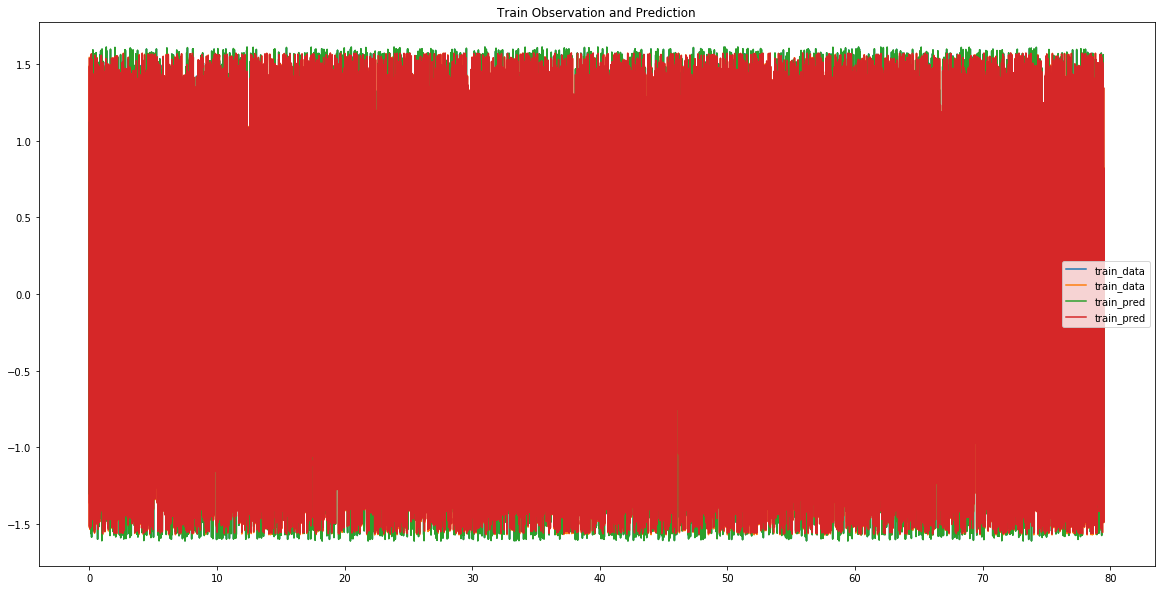

In [26]:
t_train = np.arange(0, len(y_train)*dt, dt)
plt.figure(figsize=(20,10))
plt.plot(t_train, y_train[:], label='train_data')
plt.plot(t_train, train_prediction[:], label='train_pred')
plt.title('Train Observation and Prediction')
plt.legend()